# Neural Machine Translation: English to German

Here we implement a neural machine translator using standard TensorFlow operations.


<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/packt_nlp_tensorflow_2/blob/master/Ch09-Seq2seq-Models/ch09_seq2seq.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

In [1]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import time
import json

def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")
 
# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)

print(f"TensorFlow version: {tf.__version__}")

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("No GPU found!")
  pass

TensorFlow version: 2.7.0


2022-04-28 12:50:48.922093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 12:50:48.927649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 12:50:48.928009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Downloading the Data 

First, download the data from this [page](https://nlp.stanford.edu/projects/nmt/). Place these files in a sub-folder called `data` located as `Ch09-Seq2seq-models/data`  folder. The required files are:

* File containing German sentences: [`train.de`](https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.de)
* File containing English sentences: [`train.en`](https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.en)
* File containing German vocabulary: [`vocab.50K.de`](https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/vocab.50K.de)
* File containing English vocabulary: [`vocab.50K.en`](https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/vocab.50K.en)

## Loading the data

Let's now load the sentences in `train.de` and `train.en`. Each line in these files contains a German and an English sentence respectively.

In [2]:
n_sentences = 200000

# Loading English sentences
original_en_sentences = []
with open(os.path.join('data', 'train.en'), 'r', encoding='utf-8') as en_file:
    for i,row in enumerate(en_file):
        if i < 50: continue # or i==22183 or i==27781 or i==81827: continue
        if i >= n_sentences: break
        original_en_sentences.append(row.strip().split(" "))
        
# Loading German sentences
original_de_sentences = []
with open(os.path.join('data', 'train.de'), 'r', encoding='utf-8') as de_file:
    for i, row in enumerate(de_file):
        if i < 50: continue # or i==22183 or i==27781 or i==81827: continue
        if i >= n_sentences: break
        original_de_sentences.append(row.strip().split(" "))
        


In [3]:
# Print a few sentences
for de_s, en_s in zip(original_en_sentences[:10], original_de_sentences[:10]):
    print(f"{' '.join(de_s)} -> {' '.join(en_s)}\n")

Today , QuarkXPress ® 8 has tighter integration with Photoshop ® and Illustrator ® than ever before , and through standards like HTML and CSS , QuarkXPress users can publish across media both independently and alongside Adobe ® Creative Suite ® applications like Adobe Flash ® ( SWF ) and Adobe Dreamweaver ® . -> Heute verstehen sich QuarkXPress ® 8 , Photoshop ® und Illustrator ® besser als jemals zuvor . Dank HTML und CSS ­ können Anwender von QuarkXPress inzwischen alle Medien bedienen , und das unabhängig von Anwendungen der Adobe ® Creative Suite ® wie Adobe Flash ® ( SWF ) und Adobe Dreamweaver ® .

Here , you ’ ll find out how Creative Suite users can get the best possible interaction with QuarkXPress . -> Hier erfahren Sie , wie Sie Creative Suite 2 und Creative Suite 3 am besten zusammen mit QuarkXPress nutzen können .

You ’ ll be surprised how easy Quark has made it to unlock the full potential of all your design software . -> Sie werden überrascht sein , wie einfach sich mit

## Adding special tokens

We add special tokens `<s>` and `</s>` to denote the beginning and end of sequences respectively. They play a special role when it comes to generating translations with the trained model as discussed in the book.

In [4]:
en_sentences = [["<s>"]+sent+["</s>"] for sent in original_en_sentences]
de_sentences = [["<s>"]+sent+["</s>"] for sent in original_de_sentences]

In [5]:
# Print a few sentences
for de_s, en_s in zip(en_sentences[:5], de_sentences[:5]):
    print(f"{' '.join(de_s)} -> {' '.join(en_s)}\n")

<s> Today , QuarkXPress ® 8 has tighter integration with Photoshop ® and Illustrator ® than ever before , and through standards like HTML and CSS , QuarkXPress users can publish across media both independently and alongside Adobe ® Creative Suite ® applications like Adobe Flash ® ( SWF ) and Adobe Dreamweaver ® . </s> -> <s> Heute verstehen sich QuarkXPress ® 8 , Photoshop ® und Illustrator ® besser als jemals zuvor . Dank HTML und CSS ­ können Anwender von QuarkXPress inzwischen alle Medien bedienen , und das unabhängig von Anwendungen der Adobe ® Creative Suite ® wie Adobe Flash ® ( SWF ) und Adobe Dreamweaver ® . </s>

<s> Here , you ’ ll find out how Creative Suite users can get the best possible interaction with QuarkXPress . </s> -> <s> Hier erfahren Sie , wie Sie Creative Suite 2 und Creative Suite 3 am besten zusammen mit QuarkXPress nutzen können . </s>

<s> You ’ ll be surprised how easy Quark has made it to unlock the full potential of all your design software . </s> -> <s> 

## Train, validation and test split

Here we split the full dataset as follows.
* Train - 80%
* Validation - 10%
* Test - 10%

In [6]:
from sklearn.model_selection import train_test_split

train_en_sentences, valid_test_en_sentences, train_de_sentences, valid_test_de_sentences = train_test_split(
    np.array(en_sentences), np.array(de_sentences), test_size=0.2
)

valid_en_sentences, test_en_sentences, valid_de_sentences, test_de_sentences = train_test_split(
    valid_test_en_sentences, valid_test_de_sentences, test_size=0.5)

print(f"Train size: {len(train_en_sentences)}")
print(f"Valid size: {len(valid_en_sentences)}")
print(f"Test size: {len(test_en_sentences)}")


Train size: 159960
Valid size: 19995
Test size: 19995


/tmp/ipykernel_10235/3222316697.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(en_sentences), np.array(de_sentences), test_size=0.2


## Analyse lengths of sequences

We will find out the 80% percentile of the sequence lengths for each language. We will then use this as a threshold to,
* Truncate sequences longer than that
* Add a special token (`<pad>`) to bring shorter sentences to that length

In [7]:
print("Sequence lengths (English)")
print(pd.Series(train_en_sentences).str.len().describe(percentiles=[0.2, 0.5, 0.8]))

print("Sequence lengths (German)")
print(pd.Series(train_de_sentences).str.len().describe(percentiles=[0.2, 0.5, 0.8]))

Sequence lengths (English)
count    159960.000000
mean         26.874569
std          13.529752
min           8.000000
20%          16.000000
50%          24.000000
80%          36.000000
max         102.000000
dtype: float64
Sequence lengths (German)
count    159960.000000
mean         24.648650
std          12.273613
min           8.000000
20%          15.000000
50%          22.000000
80%          33.000000
max         102.000000
dtype: float64


In [8]:
n_en_seq_length = 36
n_de_seq_length = 33

## Padding sentences to a fixed length

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

pad_token = '<pad>'

train_en_sentences_padded = pad_sequences(train_en_sentences, maxlen=n_en_seq_length, value=pad_token, dtype=object, truncating='post', padding='pre')
valid_en_sentences_padded = pad_sequences(valid_en_sentences, maxlen=n_en_seq_length, value=pad_token, dtype=object, truncating='post', padding='pre')
test_en_sentences_padded = pad_sequences(test_en_sentences, maxlen=n_en_seq_length, value=pad_token, dtype=object, truncating='post', padding='pre')

train_de_sentences_padded = pad_sequences(train_de_sentences, maxlen=n_de_seq_length, value=pad_token, dtype=object, truncating='post', padding='post')
valid_de_sentences_padded = pad_sequences(valid_de_sentences, maxlen=n_de_seq_length, value=pad_token, dtype=object, truncating='post', padding='post')
test_de_sentences_padded = pad_sequences(test_de_sentences, maxlen=n_de_seq_length, value=pad_token, dtype=object, truncating='post', padding='post')


print("Some validation sentences ...")
for en_sent, de_sent in zip(valid_en_sentences_padded[:3], valid_de_sentences_padded[:3]):
    en_sent_str = ' '.join(en_sent)
    de_sent_str = ' '.join(de_sent)
    print(f"{en_sent_str} -> {de_sent_str}")

print("Some test sentences ...")
for en_sent, de_sent in zip(test_en_sentences_padded[:3], test_de_sentences_padded[:3]):
    en_sent_str = ' '.join(en_sent)
    de_sent_str = ' '.join(de_sent)
    print(f"{en_sent_str} -> {de_sent_str}")

Some validation sentences ...
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <s> Your PC may be virus ##AT##-##AT## free , but you can still be infected with Trojans . </s> -> <s> Ihr PC kann viren ##AT##-##AT## frei , aber noch immer mit Trojanern infiziert sein . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<s> The facilities created by the combination of the &quot; darmstadtium &quot; , Darmstadt ’ s technical university , the cultural facilities in and around Karolinenplatz , the park &quot; Herrngarten &quot; and the hotel will -> <s> Ein 130 qm ² Soft ##AT##-##AT## Wellnessbereich mit Sauna , Dampfbad , Whirlwannen und Fitnessraum lädt zum Erholen und Relaxen im Obergeschoss ein . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <s> The coache

## Loading Vocabulary

First we build the vocabulary dictionaries for both the source (German) and target (English) languages. The vocabularies are found in the `vocab.50K.de` (German) and `vocab.50K.en` files.

In [10]:
n_vocab = 25000 + 1

en_vocabulary = []
with open(os.path.join('data', 'vocab.50K.en'), 'r', encoding='utf-8') as en_file:
    for ri, row in enumerate(en_file):
        if ri  >= n_vocab: break
            
        en_vocabulary.append(row.strip())
        

de_vocabulary = []
with open(os.path.join('data', 'vocab.50K.de'), 'r', encoding='utf-8') as de_file:
    for ri, row in enumerate(de_file):
        if ri >= n_vocab: break
            
        de_vocabulary.append(row.strip())
        
en_unk_token = en_vocabulary.pop(0)
de_unk_token = de_vocabulary.pop(0)

## String lookup layer: Converting tokens to IDs

Here we define a `StringLookup` layer for each language, which will convert string tokens to numerical IDs

In [11]:
en_lookup_layer = tf.keras.layers.StringLookup(
    oov_token=en_unk_token, vocabulary=en_vocabulary, mask_token=pad_token, pad_to_max_tokens=False
)

de_lookup_layer = tf.keras.layers.StringLookup(
    oov_token=de_unk_token, vocabulary=de_vocabulary, mask_token=pad_token, pad_to_max_tokens=False
)

2022-04-28 12:50:57.888442: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-28 12:50:57.888873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 12:50:57.889237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 12:50:57.889543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [12]:
wid_sample = en_lookup_layer(
    "iron cement protects the ingot against the hot , abrasive steel casting process .".split(" ")
)
print(f"Word IDs: {wid_sample}")
print(f"Sample vocabulary: {en_lookup_layer.get_vocabulary()[:10]}")

Word IDs: [ 4304 10519  6386     4     1   179     4  1840     5 19429  2315  7705
   224     6]
Sample vocabulary: ['<pad>', '<unk>', '<s>', '</s>', 'the', ',', '.', 'of', 'and', 'to']


## Defining the model

Here we define the model. We'll be focusing on the following primary components.
* Encoder - Convert an English token sequence to a context vect
* Decoder - Consumes the context vector and generate predictions
* Decoder Attention - Allows the decoder to look at any encoder state in order to learn about the source sentence

### Defining the Attention Mechanism

We will define the attention mechanism as a class below. We'll be using Bahdanau Attention.

In [13]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # Weights to compute Bahdanau attention
        self.Wa = tf.keras.layers.Dense(units, use_bias=False)
        self.Ua = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention(use_scale=True)

    def call(self, query, key, value, mask, return_attention_scores=False):

        # Compute `Wa.ht`.
        wa_query = self.Wa(query)

        # Compute `Ua.hs`.
        ua_key = self.Ua(key)

        # Compute masks
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        # Compute the attention
        context_vector, attention_weights = self.attention(
            inputs = [wa_query, value, ua_key],
            mask=[query_mask, value_mask, value_mask],
            return_attention_scores = True,
        )
        
        if not return_attention_scores:
            return context_vector
        else:
            return context_vector, attention_weights

### Defining the full model

Here we define the full model end to end. It consists for the encoder, the decoder and the attention mechanism.

In [14]:
import tensorflow.keras.backend as K
K.clear_session()

# Defining the encoder layers
encoder_input = tf.keras.layers.Input(shape=(n_en_seq_length,), dtype=tf.string)
# Converting tokens to IDs
encoder_wid_out = en_lookup_layer(encoder_input)

# Embedding layer and lookup
encoder_emb_out = tf.keras.layers.Embedding(len(en_lookup_layer.get_vocabulary()), 128, mask_zero=True)(encoder_wid_out)

# Encoder GRU layer
encoder_gru_out, encoder_gru_last_state = tf.keras.layers.GRU(256, return_sequences=True, return_state=True)(encoder_emb_out)

# Defining the encoder model: in - encoder_input / out - output of the GRU layer
encoder = tf.keras.models.Model(inputs=encoder_input, outputs=encoder_gru_out)

# Defining the decoder layers 
decoder_input = tf.keras.layers.Input(shape=(n_de_seq_length-1,), dtype=tf.string)
# Converting tokens to IDs (Decoder)
decoder_wid_out = de_lookup_layer(decoder_input)

# Embedding layer and lookup (decoder)
full_de_vocab_size = len(de_lookup_layer.get_vocabulary())
decoder_emb_out = tf.keras.layers.Embedding(full_de_vocab_size, 128, mask_zero=True)(decoder_wid_out)
decoder_gru_out = tf.keras.layers.GRU(256, return_sequences=True)(decoder_emb_out, initial_state=encoder_gru_last_state)

# The attention mechanism (inputs: [q, v, k])
decoder_attn_out, attn_weights = BahdanauAttention(256)(
    query=decoder_gru_out, key=encoder_gru_out, value=encoder_gru_out,
    mask=(encoder_wid_out != 0),
    return_attention_scores=True
)

# Concatenate GRU output and the attention output
context_and_rnn_output = tf.keras.layers.Concatenate(axis=-1)([decoder_attn_out, decoder_gru_out])

# Final prediction layer (size of the vocabulary)
decoder_out = tf.keras.layers.Dense(full_de_vocab_size, activation='softmax')(context_and_rnn_output)

# Final seq2seq model
seq2seq_model = tf.keras.models.Model(inputs=[encoder.inputs, decoder_input], outputs=decoder_out)

# We will use this model later to visualize attention patterns
attention_visualizer = tf.keras.models.Model(inputs=[encoder.inputs, decoder_input], outputs=[attn_weights, decoder_out])

# Compiling the model with a loss and an optimizer
seq2seq_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

# Print model summary
seq2seq_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 36)           0           ['input_1[0][0]']                
                                                                                                  
 string_lookup_1 (StringLookup)  (None, 32)          0           ['input_2[0][0]']                
                                                                                            

## Computing BLEU score

BLEU score measures the quality/accuracy of translations produced by the model. BLEU score looks at `n`-grams of tokens produced by the decoder to measure how "close" the predicted translation is to the actual ground truth sequence.

In [15]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from bleu import compute_bleu

class BLEUMetric(object):
    
    def __init__(self, vocabulary, name='perplexity', **kwargs):
      """ Computes the BLEU score (Metric for machine translation) """
      super().__init__()
      self.vocab = vocabulary
      self.id_to_token_layer = StringLookup(vocabulary=self.vocab, invert=True)
    
    def calculate_bleu_from_predictions(self, real, pred):
        """ Calculate the BLEU score for targets and predictions """
        
        # Get the predicted token IDs
        pred_argmax = tf.argmax(pred, axis=-1)  
        
        # Convert token IDs to words using the vocabulary and the StringLookup
        pred_tokens = self.id_to_token_layer(pred_argmax)
        real_tokens = self.id_to_token_layer(real)
        
        def clean_text(tokens):
            
            """ Clean padding and <s>/</s> tokens to only keep meaningful words """
            
            # 3. Strip the string of any extra white spaces
            translations_in_bytes = tf.strings.strip(
                        # 2. Replace everything after the eos token with blank
                        tf.strings.regex_replace(
                            # 1. Join all the tokens to one string in each sequence
                            tf.strings.join(
                                tf.transpose(tokens), separator=' '
                            ),
                        "<\/s>.*", ""),
                   )
            
            # Decode the byte stream to a string
            translations = np.char.decode(
                translations_in_bytes.numpy().astype(np.bytes_), encoding='utf-8'
            )
            
            # If the string is empty, add a [UNK] token
            # Otherwise get a Division by zero error
            translations = [sent if len(sent)>0 else en_unk_token for sent in translations ]
            
            # Split the sequences to individual tokens 
            translations = np.char.split(translations).tolist()
            
            return translations
        
        # Get the clean versions of the predictions and real seuqences
        pred_tokens = clean_text(pred_tokens)
        # We have to wrap each real sequence in a list to make use of a function to compute bleu
        real_tokens = [[token_seq] for token_seq in clean_text(real_tokens)]

        # The compute_bleu method accpets the translations and references in the following format
        # tranlation - list of list of tokens
        # references - list of list of list of tokens
        bleu, precisions, bp, ratio, translation_length, reference_length = compute_bleu(real_tokens, pred_tokens, smooth=False)

        return bleu

### Computing BLEU example

In [16]:
translation = [[de_unk_token, de_unk_token, 'mÃssen', 'wir', 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]
reference = [[['als', 'mÃssen', 'mÃssen', 'wir', 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]]

bleu1, _, _, _, _, _ = compute_bleu(reference, translation)

translation = [[de_unk_token, 'einmal', 'mÃssen', en_unk_token, 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]
reference = [[['als', 'mÃssen', 'mÃssen', 'wir', 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]]


bleu2, _, _, _, _, _ = compute_bleu(reference, translation)

print(f"BLEU score with longer correctly predicte phrases: {bleu1}")
print(f"BLEU score without longer correctly predicte phrases: {bleu2}")

BLEU score with longer correctly predicte phrases: 0.7598356856515925
BLEU score without longer correctly predicte phrases: 0.537284965911771


## Training the model

Here we define several utility functions to train the model.

* `prepare_data()` - Prepares source/target language sentences by generating encoder inputs, decoder inputs and decoder labels
* `shuffle_data()` - Shuffle the generated inputs randomly
* `train_model()` - Trans the model on a given dataset
* `evaluate_model()` - Evaluates the model on a given dataset
* `check_for_nan()` - Check if any samples causing NaN values

In [17]:
# Section 11.3
import time


def prepare_data(de_lookup_layer, train_xy, valid_xy, test_xy):
    """ Create a data dictionary from the dataframes containing data """
    
    data_dict = {}
    for label, data_xy in zip(['train', 'valid', 'test'], [train_xy, valid_xy, test_xy]):
        
        data_x, data_y = data_xy
        en_inputs = data_x
        de_inputs = data_y[:,:-1]
        de_labels = de_lookup_layer(data_y[:,1:]).numpy()
        data_dict[label] = {'encoder_inputs': en_inputs, 'decoder_inputs': de_inputs, 'decoder_labels': de_labels}
    
    return data_dict


def shuffle_data(en_inputs, de_inputs, de_labels, shuffle_inds=None): 
    """ Shuffle the data randomly (but all of inputs and labels at ones)"""
        
    if shuffle_inds is None:
        # If shuffle_inds are not passed create a shuffling automatically
        shuffle_inds = np.random.permutation(np.arange(en_inputs.shape[0]))
    else:
        # Shuffle the provided shuffle_inds
        shuffle_inds = np.random.permutation(shuffle_inds)
    
    # Return shuffled data
    return (en_inputs[shuffle_inds], de_inputs[shuffle_inds], de_labels[shuffle_inds]), shuffle_inds
 

def check_for_nans(loss, model, en_lookup_layer, de_lookup_layer):
    
    if np.isnan(loss):
        for r_i in range(len(y)):
            loss_sample, _  = model.evaluate([x[0][r_i:r_i+1], x[1][r_i:r_i+1]], y[r_i:r_i+1], verbose=0)
            if np.isnan(loss_sample):

                print('='*25, 'nan detected', '='*25)
                print('train_batch', i, 'r_i', r_i)
                print('en_input ->', x[0][r_i].tolist())
                print('en_input_wid ->', en_lookup_layer(x[0][r_i]).numpy().tolist())
                print('de_input ->', x[1][r_i].tolist())
                print('de_input_wid ->', de_lookup_layer(x[1][r_i]).numpy().tolist())
                print('de_output_wid ->', y[r_i].tolist())

                if r_i > 0:
                    print('='*25, 'no-nan', '='*25)
                    print('en_input ->', x[0][r_i-1].tolist())
                    print('en_input_wid ->', en_lookup_layer(x[0][r_i-1]).numpy().tolist())
                    print('de_input ->', x[1][r_i-1].tolist())
                    print('de_input_wid ->', de_lookup_layer(x[1][r_i-1]).numpy().tolist())
                    print('de_output_wid ->', y[r_i-1].tolist())
                    return
                else:
                    continue
                    
                    
def train_model(model, en_lookup_layer, de_lookup_layer, train_xy, valid_xy, test_xy, epochs, batch_size, shuffle=True, predict_bleu_at_training=False):
    """ Training the model and evaluating on validation/test sets """
    
    # Define the metric
    bleu_metric = BLEUMetric(de_vocabulary)

    # Define the data
    data_dict = prepare_data(de_lookup_layer, train_xy, valid_xy, test_xy)

    shuffle_inds = None
    
    
    for epoch in range(epochs):

        # Reset metric logs every epoch
        if predict_bleu_at_training:
            blue_log = []
        accuracy_log = []
        loss_log = []

        # =================================================================== #
        #                         Train Phase                                 #
        # =================================================================== #

        # Shuffle data at the beginning of every epoch
        if shuffle:
            (en_inputs_raw,de_inputs_raw,de_labels), shuffle_inds  = shuffle_data(
                data_dict['train']['encoder_inputs'],
                data_dict['train']['decoder_inputs'],
                data_dict['train']['decoder_labels'],
                shuffle_inds
            )
        else:
            (en_inputs_raw,de_inputs_raw,de_labels)  = (
                data_dict['train']['encoder_inputs'],
                data_dict['train']['decoder_inputs'],
                data_dict['train']['decoder_labels'],
            )
        # Get the number of training batches
        n_train_batches = en_inputs_raw.shape[0]//batch_size
        
        prev_loss = None
        # Train one batch at a time
        for i in range(n_train_batches):
            # Status update
            print(f"Training batch {i+1}/{n_train_batches}", end='\r')

            # Get a batch of inputs (english and german sequences)
            x = [en_inputs_raw[i*batch_size:(i+1)*batch_size], de_inputs_raw[i*batch_size:(i+1)*batch_size]]
            # Get a batch of targets (german sequences offset by 1)
            y = de_labels[i*batch_size:(i+1)*batch_size]
            
            loss, accuracy = model.evaluate(x, y, verbose=0)
            
            # Check if any samples are causing NaNs
            check_for_nans(loss, model, en_lookup_layer, de_lookup_layer)
                
            # Train for a single step
            model.train_on_batch(x, y)        
            # Evaluate the model to get the metrics
            #loss, accuracy = model.evaluate(x, y, verbose=0)

            
            # Update the epoch's log records of the metrics
            loss_log.append(loss)
            accuracy_log.append(accuracy)
            
            if predict_bleu_at_training:
                # Get the final prediction to compute BLEU
                pred_y = model.predict(x)
                bleu_log.append(bleu_metric.calculate_bleu_from_predictions(y, pred_y))
        
        print("")
        print(f"\nEpoch {epoch+1}/{epochs}")
        if predict_bleu_at_training:
            print(f"\t(train) loss: {np.mean(loss_log)} - accuracy: {np.mean(accuracy_log)} - bleu: {np.mean(bleu_log)}")
        else:
            print(f"\t(train) loss: {np.mean(loss_log)} - accuracy: {np.mean(accuracy_log)}")
        # =================================================================== #
        #                      Validation Phase                               #
        # =================================================================== #
        
        val_en_inputs = data_dict['valid']['encoder_inputs']
        val_de_inputs = data_dict['valid']['decoder_inputs']
        val_de_labels = data_dict['valid']['decoder_labels']
            
        val_loss, val_accuracy, val_bleu = evaluate_model(
            model, de_lookup_layer, val_en_inputs, val_de_inputs, val_de_labels, batch_size
        )
            
        # Print the evaluation metrics of each epoch
        print(f"\t(valid) loss: {val_loss} - accuracy: {val_accuracy} - bleu: {val_bleu}")
    
    # =================================================================== #
    #                      Test Phase                                     #
    # =================================================================== #    
    
    test_en_inputs = data_dict['test']['encoder_inputs']
    test_de_inputs = data_dict['test']['decoder_inputs']
    test_de_labels = data_dict['test']['decoder_labels']
            
    test_loss, test_accuracy, test_bleu = evaluate_model(
            model, de_lookup_layer, test_en_inputs, test_de_inputs, test_de_labels, batch_size
    )
    
    print(f"\n(test) loss: {test_loss} - accuracy: {test_accuracy} - bleu: {test_bleu}")


def evaluate_model(model, de_lookup_layer, en_inputs_raw, de_inputs_raw, de_labels, batch_size):
    """ Evaluate the model on various metrics such as loss, accuracy and BLEU """
    
    # Define the metric
    bleu_metric = BLEUMetric(de_vocabulary)
    
    loss_log, accuracy_log, bleu_log = [], [], []
    # Get the number of batches
    n_batches = en_inputs_raw.shape[0]//batch_size
    print(" ", end='\r')

    # Evaluate one batch at a time
    for i in range(n_batches):
        # Status update
        print(f"Evaluating batch {i+1}/{n_batches}", end='\r')

        # Get the inputs and targers
        x = [en_inputs_raw[i*batch_size:(i+1)*batch_size], de_inputs_raw[i*batch_size:(i+1)*batch_size]]
        y = de_labels[i*batch_size:(i+1)*batch_size]

        # Get the evaluation metrics
        loss, accuracy = model.evaluate(x, y, verbose=0)
        # Get the predictions to compute BLEU
        pred_y = model.predict(x)

        # Update logs
        loss_log.append(loss)
        accuracy_log.append(accuracy)
        bleu_log.append(bleu_metric.calculate_bleu_from_predictions(y, pred_y))
    
    return np.mean(loss_log), np.mean(accuracy_log), np.mean(bleu_log)
   

### Training the model

In [18]:

epochs = 10
batch_size = 72

t1 = time.time()    
train_model(
    seq2seq_model, 
    en_lookup_layer, de_lookup_layer, 
    (train_en_sentences_padded, train_de_sentences_padded), 
    (valid_en_sentences_padded, valid_de_sentences_padded), 
    (test_en_sentences_padded, test_de_sentences_padded), 
    epochs, 
    batch_size,
    shuffle=False
)
t2 = time.time()

print(f"\nIt took {t2-t1} seconds to complete the training")

2022-04-28 12:51:08.637897: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2070" frequency: 1620 num_cores: 36 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 6647185408 bandwidth: 448064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-04-28 12:51:09.429110: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8400
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.0/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2022-04-28 12:51:12.435480: W tensorflow/core

Training batch 2221/2221

Epoch 1/10
	(train) loss: 3.366314321850292 - accuracy: 0.27472094663799157


2022-04-28 13:04:27.766499: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2070" frequency: 1620 num_cores: 36 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 6647185408 bandwidth: 448064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-04-28 13:04:28.148126: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 230418432 exceeds 10% of free system memory.
2022-04-28 13:04:28.416509: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 230418432 exceeds 10% of free system memory.


2022-04-28 13:04:28.842882: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 230418432 exceeds 10% of free system memory.


2022-04-28 13:04:28.976180: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 230418432 exceeds 10% of free system memory.
2022-04-28 13:04:29.400509: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 230418432 exceeds 10% of free system memory.


	(valid) loss: 2.892027324717828 - accuracy: 0.32744156561173254 - bleu: 0.08363572032819594
Training batch 2221/2221

Epoch 2/10
	(train) loss: 2.63884367904165 - accuracy: 0.35787885546523246
	(valid) loss: 2.504915570524195 - accuracy: 0.389230030000425 - bleu: 0.1171179493832336
Training batch 2221/2221

Epoch 3/10
	(train) loss: 2.251980893303821 - accuracy: 0.4184786721775522
	(valid) loss: 2.3345831529328107 - accuracy: 0.420228735419387 - bleu: 0.1381101839974948
Training batch 2221/2221

Epoch 4/10
	(train) loss: 2.0249068271142305 - accuracy: 0.4520536792917007
	(valid) loss: 2.29145005764944 - accuracy: 0.4291160463856446 - bleu: 0.14427407197433018
Training batch 2221/2221

Epoch 5/10
	(train) loss: 1.8726273275398553 - accuracy: 0.47494535575520613
	(valid) loss: 2.3049646826857693 - accuracy: 0.42808433205212065 - bleu: 0.14288747418969813
Training batch 2221/2221

Epoch 6/10
	(train) loss: 1.7533364618001677 - accuracy: 0.4947594103379488
	(valid) loss: 2.313548989674675

## Visualizing attention patterns

Here we randomly sample some test data and use the `attention_visualizer` model to visualize attention patterns.

In [19]:
def get_attention_matrix_for_sampled_data(attention_model, target_lookup_layer, test_xy, n_samples=5):
    
    test_x, test_y = test_xy
    
    rand_ids = np.random.randint(0, len(test_xy[0]), size=(n_samples,))
    print(rand_ids)
    results = []
    
    for rid in rand_id
    s:
        en_input = test_x[rid:rid+1]
        de_input = test_y[rid:rid+1,:-1]
        
        clean_en_input = []
        en_start_i = 0
        for i, w in enumerate(en_input.ravel()):
            if w=='<pad>': 
                en_start_i = i+1
                continue
                
            clean_en_input.append(w)
            if w=='</s>': break
                
        attn_weights, predictions = attention_model.predict([en_input, de_input])
        predicted_word_ids = np.argmax(predictions, axis=-1).ravel()
        predicted_words = [target_lookup_layer.get_vocabulary()[wid] for wid in predicted_word_ids]
        
        clean_predicted_words = []
        for w in predicted_words:
            clean_predicted_words.append(w)
            if w=='</s>': break
        
        results.append(
            {
                "attention_weights": attn_weights[
                    0,:len(clean_predicted_words),en_start_i:en_start_i+len(clean_en_input)
                ], 
                "input_words": clean_en_input,  
                "predicted_words": clean_predicted_words
            }
        )
        
    return results
    

[ 4126 18138 16447  5090 10325]


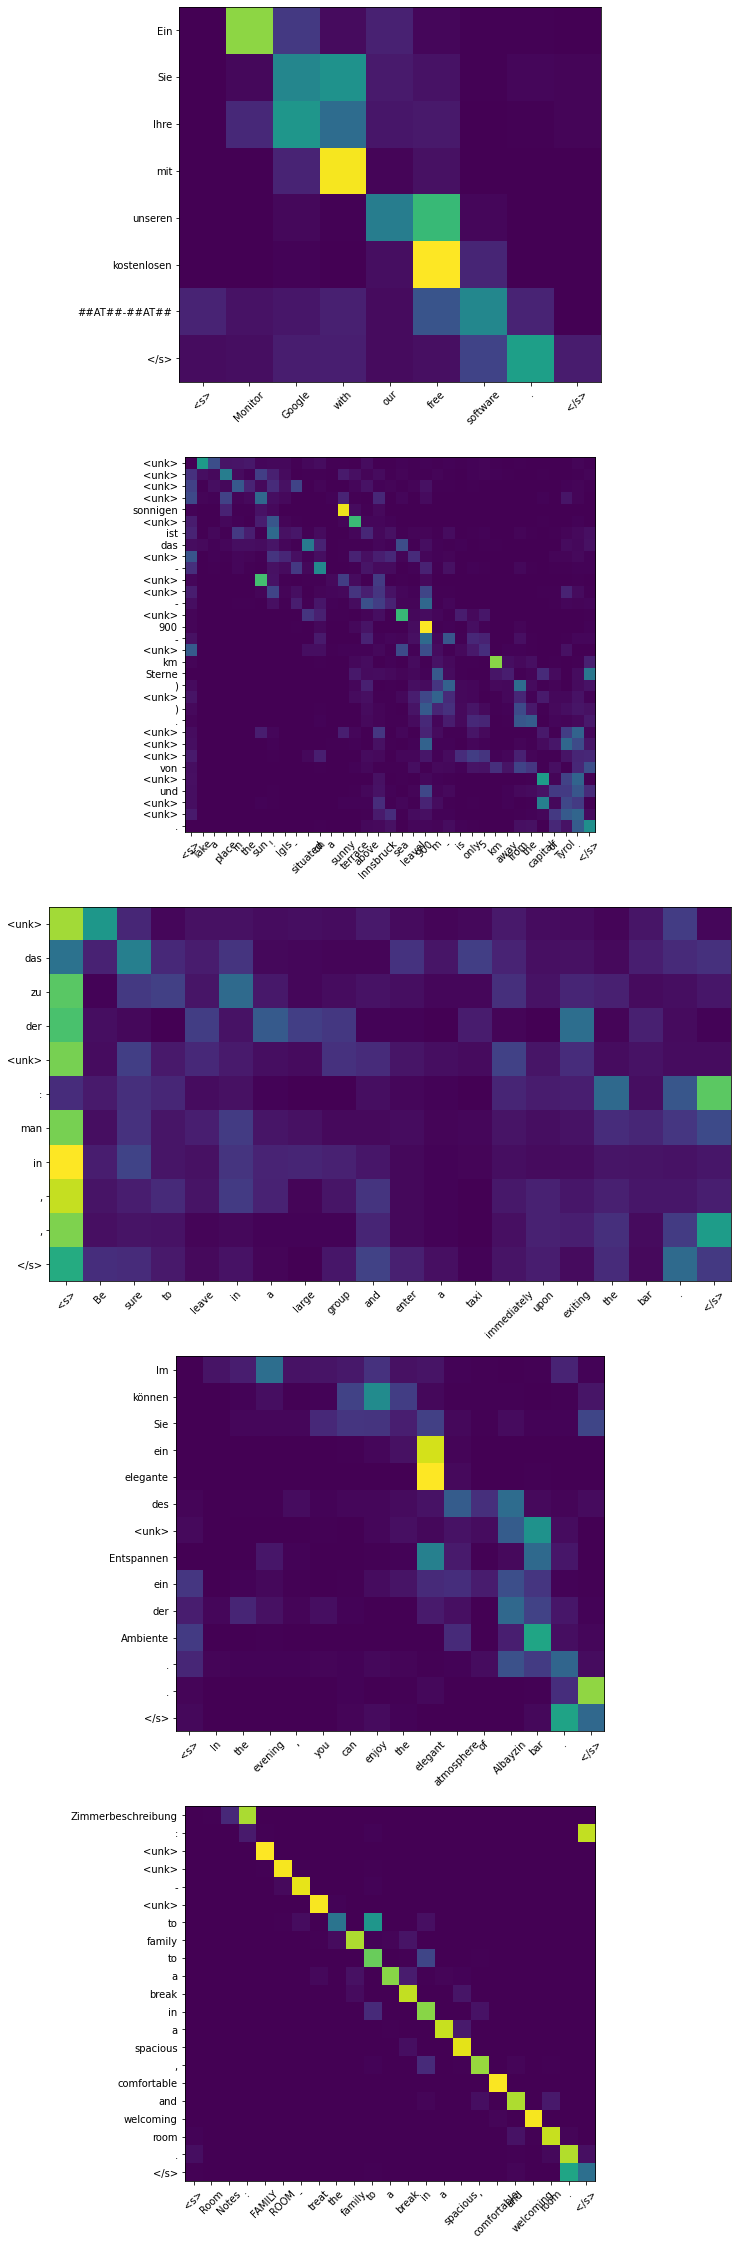

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

_, axes = plt.subplots(5, 1, figsize=(24,40))

attention_results = get_attention_matrix_for_sampled_data(
    attention_visualizer, 
    de_lookup_layer, 
    (test_en_sentences_padded, test_de_sentences_padded),
    n_samples = 5
)

for ax, result in zip(axes, attention_results):
    
    ax.imshow(result["attention_weights"])
    x_labels = result["input_words"]
    y_labels = result["predicted_words"]
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels, rotation=0)


## Defining the inference model

In [21]:
# Defining the encoder layers
encoder_input = tf.keras.layers.Input(shape=(n_en_seq_length,), dtype=tf.string)
# Converting tokens to IDs
en_lookup_layer = seq2seq_model.get_layer("string_lookup")
encoder_wid_out = en_lookup_layer(encoder_input)

# Embedding layer and lookup
en_emb_layer = seq2seq_model.get_layer("embedding")
encoder_emb_out = en_emb_layer(encoder_wid_out)

# Encoder GRU layer
en_gru_layer = seq2seq_model.get_layer("gru")
encoder_gru_out, encoder_gru_last_state = en_gru_layer(encoder_emb_out)

# Defining the encoder model: in - encoder_input / out - output of the GRU layer
encoder_model = tf.keras.models.Model(inputs=encoder_input, outputs=[encoder_gru_out, encoder_gru_last_state])

# Defining the decoder layers 
decoder_input = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
decoder_init_state_input = tf.keras.layers.Input(shape=(256,))
encoder_state_input = tf.keras.layers.Input(shape=(n_en_seq_length,256))
encoder_input_mask = tf.keras.layers.Input(shape=(n_en_seq_length,), dtype=tf.bool)

# Converting tokens to IDs (Decoder)
de_lookup_layer = seq2seq_model.get_layer("string_lookup_1")
decoder_wid_out = de_lookup_layer(decoder_input)

# Embedding layer and lookup (decoder)
de_emb_layer = seq2seq_model.get_layer("embedding_1")
decoder_emb_out = de_emb_layer(decoder_wid_out)

de_gru_layer = tf.keras.layers.GRU(256, return_sequences=True)
decoder_gru_out = de_gru_layer(decoder_emb_out, initial_state=decoder_init_state_input)

# The attention mechanism (inputs: [q, v, k])
attention_layer = seq2seq_model.get_layer("bahdanau_attention")
decoder_attn_out, attn_weights = attention_layer(
    query=decoder_gru_out, key=encoder_state_input, value=encoder_state_input,
    mask=encoder_input_mask,
    return_attention_scores=True
)

# Concatenate GRU output and the attention output
context_and_rnn_output = tf.keras.layers.Concatenate(axis=-1)([decoder_attn_out, decoder_gru_out])

# Final prediction layer (size of the vocabulary)
de_dense_layer = seq2seq_model.get_layer("dense_2")
decoder_out = de_dense_layer(context_and_rnn_output)

# Final seq2seq model
decoder_model = tf.keras.models.Model(
    inputs=[decoder_input, decoder_init_state_input, encoder_state_input, encoder_input_mask], 
    outputs=[decoder_out, decoder_gru_out]
)

decoder_model.compile()
de_gru_layer.set_weights(seq2seq_model.get_layer("gru_1").get_weights())




## Generating new translation

In [22]:
def generate_translation(en_sentence, en_lookup_layer, encoder_model, de_lookup_layer, decoder_model):
    
    de_vocabulary = de_lookup_layer.get_vocabulary()
    en_out, de_gru_state = encoder_model(en_sentence)
    
    y_pred = np.array([["<s>"]])
    predicted_sentence = [y_pred[0][0]]
    
    for _ in range(100):
        
        if y_pred == "</s>":
            break
            
        y_pred_probs, de_gru_state = decoder_model.predict([y_pred, de_gru_state, en_out, (en_sentence != pad_token)])
        de_gru_state = de_gru_state[:, 0, :]
        y_pred_wid = np.argmax(y_pred_probs, axis=-1).ravel()[0]
        y_pred = np.array([[de_vocabulary[y_pred_wid]]])
        predicted_sentence.append(y_pred[0][0])
    
    return ' '.join(predicted_sentence)

for en_sentence, de_sentence in zip(test_en_sentences_padded[:5,:], test_de_sentences_padded[:5,:]):
    
    en_sentence_string = ' '.join([en_word for en_word in en_sentence if en_word != pad_token])
    print(f"EN: {en_sentence_string}")
    de_sentence_string = ' '.join([de_word for de_word in de_sentence if de_word != pad_token])
    print(f"DE (true): {de_sentence_string}")
    
    de_predicted = generate_translation(
        en_sentence.reshape(1, -1), en_lookup_layer, encoder_model, de_lookup_layer, decoder_model
    )
    print(f"DE (predicted): {de_predicted}\n")

EN: <s> After checking your booking details and entering all the required information , you can continue with the online prepayment . </s>
DE (true): <s> Nachdem Sie Ihre Buchungsdetails überprüft haben und alle benötigten Informationen eingegeben haben , können Sie fortfahren und die Online ##AT##-##AT## Anzahlung vornehmen . </s>
DE (predicted): <s> Nach der Buchung des <unk> und der <unk> können Sie sich mit der Online ##AT##-##AT## Niederlassung . </s>

EN: <s> East Africa is a country with diverse scenery but primarily offers the highest concentration of wildlife in its National parks unrivaled to any other part in Africa . </s>
DE (true): <s> Ein Land mit vielfältigen Landschaften und einem sagenhaften Tierreichtum wie Sie es nirgendwo sonst in Afrika finden werden . </s>
DE (predicted): <s> <unk> ist ein Land mit vielen <unk> , aber auch im Süden von Belize <unk> , in der <unk> <unk> , <unk> und <unk> . </s>

EN: <s> Production of high pressure hoses , Production of high pressur